# Retail Store Analysis

## Goal: In this workbook, we try to improve upon the Datathon2023 submission in which we used XGBoost algorithm to predict the Total Profit in the last 3 months of 2018

In [1]:
import pandas as pd
import numpy as np
import dateutil
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from apyori import apriori
import os
import datetime
import warnings
warnings.filterwarnings("ignore")
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
df = pd.read_csv('DubsTech-Datathon-2023/Data/sales_data_2017_2018_for_tableau_with_new_date_columns.csv')
df.head()

,receipt_id,date,hour,quarter,year,month_number,month_name,day_of_week_name,week_number,is_weekday,is_weekend,item_code,item_name,main_category,sub_category,quantity,payment_type,unit_buying_price,unit_selling_price,unit_price_margin,total_buying_price,total_selling_price,total_profit
0,14b5b35b-4155-45c5-9fa1-58e81d508a25,4/2/2018 2:16:32 PM,14,2,2018,4,April,Monday,14,1,0,1109.0,Tomatoes Roma,Fresh Produce,Tomatoes,0.132,cash,0.0,4.99,4.99,0.0,0.65868,0.65868
1,45755456-0890-450a-af1b-b10b0c197af4,1/25/2018 11:54:20 AM,11,1,2018,1,January,Thursday,4,1,0,1109.0,Tomatoes Roma,Fresh Produce,Tomatoes,0.134,cash,0.0,4.99,4.99,0.0,0.66866,0.66866
2,48910672-6e70-4c1a-8efc-e348c45d519c,4/13/2018 5:40:15 PM,17,2,2018,4,April,Friday,15,1,0,1109.0,Tomatoes Roma,Fresh Produce,Tomatoes,0.136,cash,0.0,4.99,4.99,0.0,0.67864,0.67864
3,dd2882f2-4211-4828-bccb-b53821d29559,1/11/2018 1:44:42 PM,13,1,2018,1,January,Thursday,2,1,0,1109.0,Tomatoes Roma,Fresh Produce,Tomatoes,0.138,cash,0.0,4.99,4.99,0.0,0.68862,0.68862
4,142d4d58-c63b-4fff-80c0-da43e87a2070,1/18/2018 2:28:24 PM,14,1,2018,1,January,Thursday,3,1,0,1109.0,Tomatoes Roma,Fresh Produce,Tomatoes,0.144,cash,0.0,4.99,4.99,0.0,0.71856,0.71856


## Data Cleaning & Manipulation

In [4]:
# Converting the datetime col type
df['date'] = pd.to_datetime(df['date'])

# Removing Duplicates
df.drop_duplicates(inplace = True)

In [5]:
df.head()

,receipt_id,date,hour,quarter,year,month_number,month_name,day_of_week_name,week_number,is_weekday,is_weekend,item_code,item_name,main_category,sub_category,quantity,payment_type,unit_buying_price,unit_selling_price,unit_price_margin,total_buying_price,total_selling_price,total_profit
0,14b5b35b-4155-45c5-9fa1-58e81d508a25,2018-04-02 14:16:32,14,2,2018,4,April,Monday,14,1,0,1109.0,Tomatoes Roma,Fresh Produce,Tomatoes,0.132,cash,0.0,4.99,4.99,0.0,0.65868,0.65868
1,45755456-0890-450a-af1b-b10b0c197af4,2018-01-25 11:54:20,11,1,2018,1,January,Thursday,4,1,0,1109.0,Tomatoes Roma,Fresh Produce,Tomatoes,0.134,cash,0.0,4.99,4.99,0.0,0.66866,0.66866
2,48910672-6e70-4c1a-8efc-e348c45d519c,2018-04-13 17:40:15,17,2,2018,4,April,Friday,15,1,0,1109.0,Tomatoes Roma,Fresh Produce,Tomatoes,0.136,cash,0.0,4.99,4.99,0.0,0.67864,0.67864
3,dd2882f2-4211-4828-bccb-b53821d29559,2018-01-11 13:44:42,13,1,2018,1,January,Thursday,2,1,0,1109.0,Tomatoes Roma,Fresh Produce,Tomatoes,0.138,cash,0.0,4.99,4.99,0.0,0.68862,0.68862
4,142d4d58-c63b-4fff-80c0-da43e87a2070,2018-01-18 14:28:24,14,1,2018,1,January,Thursday,3,1,0,1109.0,Tomatoes Roma,Fresh Produce,Tomatoes,0.144,cash,0.0,4.99,4.99,0.0,0.71856,0.71856


### Standardizing names

In [6]:
# 1.1 

df['main_category'].replace('Beverages','Beverage', regex=True, inplace = True)


# 2.1

df['sub_category'].replace('Biscuits','Biscuit', regex=True, inplace = True)
df['sub_category'].replace('Cocunut Products','Coconut Products', regex=True, inplace = True)
df['sub_category'].replace('Condiments','Condiment', regex=True, inplace = True)
df['sub_category'].replace('Packaed','Packaged', regex=True, inplace = True)
df['sub_category'].replace('Sauces','Sauce', regex=True, inplace = True)
df['sub_category'].replace('Spides','Spices', regex=True, inplace = True)
df['sub_category'].replace('Sweets','Sweet', regex=True, inplace = True)
df['sub_category'].replace('spices','Spices', regex=True, inplace = True)


# Convert all Item_names to Sentence Case

df['item_name'] = df['item_name'].str.title()

### Data Imputation for Null values

In [7]:
df.isnull().sum()

receipt_id                 0
date                       0
hour                       0
quarter                    0
year                       0
month_number               0
month_name                 0
day_of_week_name           0
week_number                0
is_weekday                 0
is_weekend                 0
item_code                  0
item_name                  0
main_category              0
sub_category               0
quantity                   0
payment_type               0
unit_buying_price      85315
unit_selling_price         0
unit_price_margin          0
total_buying_price     85315
total_selling_price        0
total_profit               0
dtype: int64

In [8]:
df['unit_buying_price'] = df['unit_selling_price'] - df['unit_price_margin']
df['total_buying_price'] = df['total_selling_price'] - df['total_profit']

### Adding Flag for Holidays

We had observed a clear trend in Profits for the various receipts and noticed that this coincided with the Holidays at times. Thus we are adding a new column, isholiday, as a flag

In [9]:
#Defining specific holiday
australia_day = ['2018-01-26', '2018-01-27', '2018-01-28', '2017-01-26', '2017-01-27', '2017-01-28', '2017-01-28', '2017-01-29']
queens_bday_week = ['2018-06-08', '2018-06-09', '2018-06-10', '2017-06-09', '2017-06-10', '2017-06-11', '2017-06-12' ]
christmas_newyear_week = ['2017-01-01', '2017-12-24', '2017-12-25', '2017-12-26', '2017-12-27', '2017-12-28', '2017-12-29', '2017-12-30', \
                          '2017-12-31', '2018-12-22', '2018-12-23', '2018-12-24', '2018-12-25', '2018-12-26', '2018-12-27', '2018-12-28', \
                            '2018-12-29', '2018-12-30', '2018-12-31', '2018-01-01']

all_holidays = australia_day + queens_bday_week + christmas_newyear_week

df['just_date'] = pd.to_datetime(df['date'].dt.date)
df['isHoliday'] = 0
df.loc[df['just_date'].isin(all_holidays), 'isHoliday'] = 1

In [10]:
df['isHoliday'].value_counts()

0    358320
1     12427
Name: isHoliday, dtype: int64

### The store changed its timings from 24 hours to 7am-7pm in 2018. Thus for our prediction, we only consider observations in the 7am-7pm timeslot.

In [11]:
#Removing purchases before 7 AM and after 7 PM to ensure uniformity in pattern
df = df.loc[(df['date'].dt.hour <= 19) & (df['date'].dt.hour >= 7)]

In [12]:
df['isYear2017'] = df['year'].apply(lambda x: 1 if x == 2017 else 0)

In [13]:
df.columns

Index(['receipt_id', 'date', 'hour', 'quarter', 'year', 'month_number',
       'month_name', 'day_of_week_name', 'week_number', 'is_weekday',
       'is_weekend', 'item_code', 'item_name', 'main_category', 'sub_category',
       'quantity', 'payment_type', 'unit_buying_price', 'unit_selling_price',
       'unit_price_margin', 'total_buying_price', 'total_selling_price',
       'total_profit', 'just_date', 'isHoliday', 'isYear2017'],
      dtype='object')

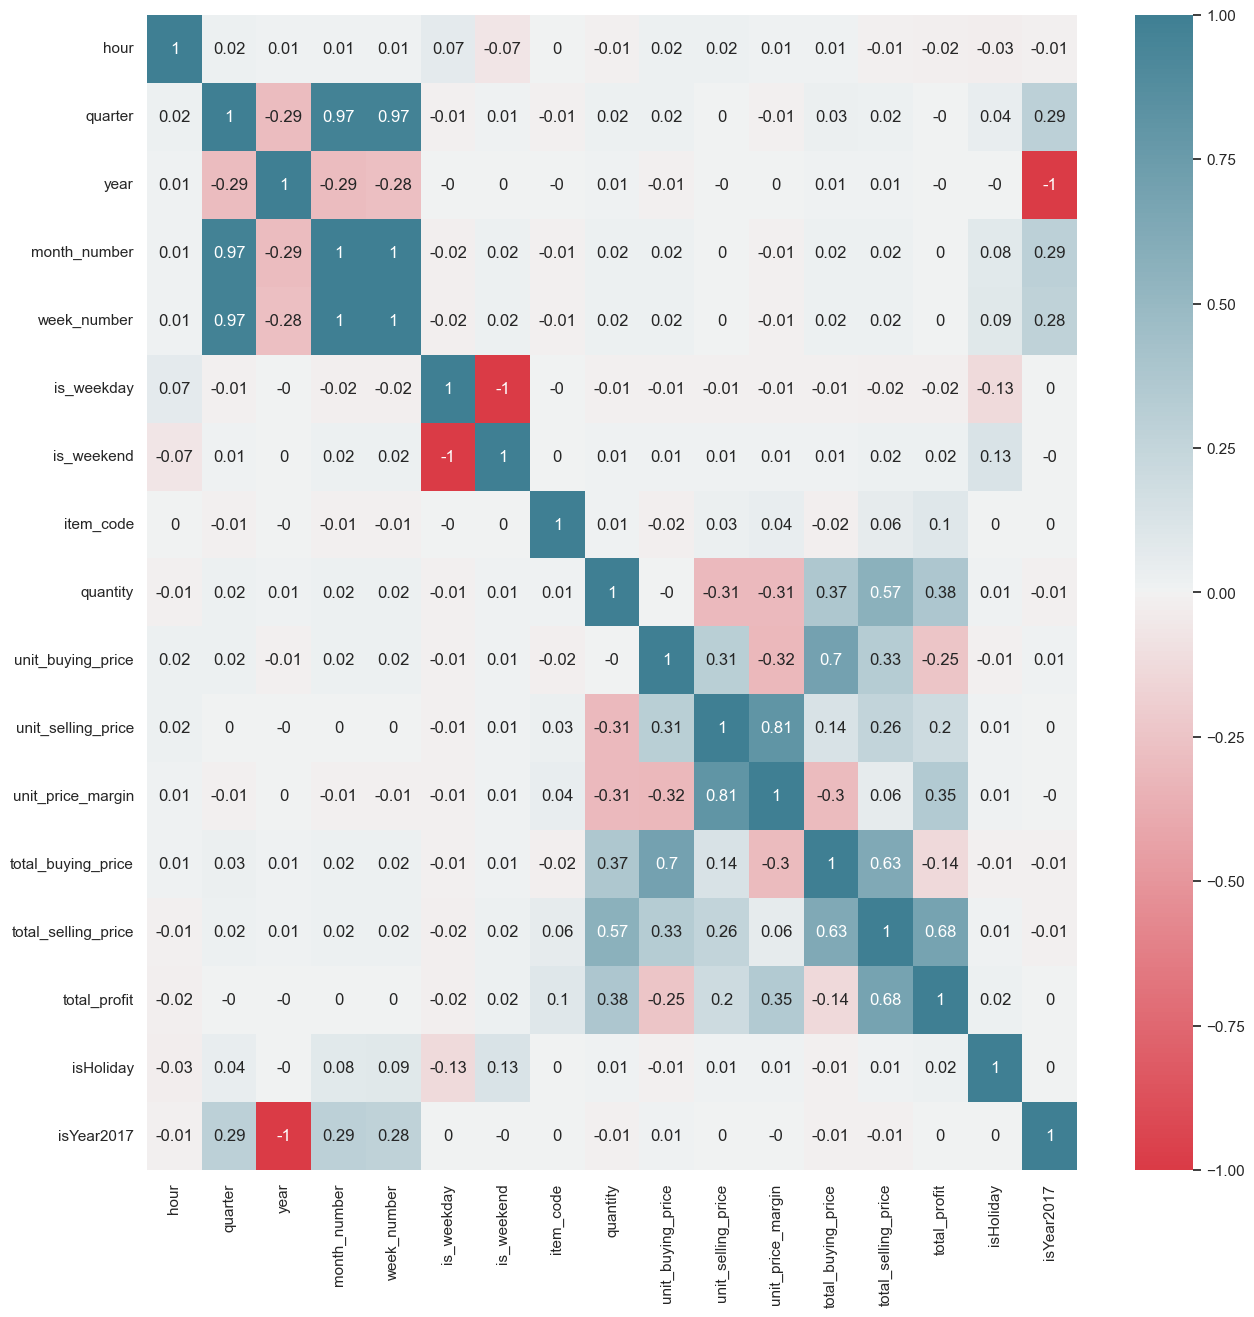

In [14]:
df_subset = df[['date','year','is_weekend','item_code','item_name', 'main_category', 'sub_category',
       'quantity', 'payment_type', 'unit_buying_price', 'unit_selling_price',
       'unit_price_margin', 'total_buying_price', 'total_selling_price',
       'total_profit', 'isHoliday']]

corr_matrix = round(df.corr(),2)

cmap = sns.diverging_palette(10, 220, as_cmap=True)

sns.set(rc={'figure.figsize':(15,15)})
s = sns.heatmap(corr_matrix, annot=True, cmap=cmap)


## Feature Engineering

* Scaling of Numerical Features
* Using One-hot encoding for Categorical Features
* Adding 'date' column separately

In [15]:
df.set_index('date')
df.head()

,receipt_id,date,hour,quarter,year,month_number,month_name,day_of_week_name,week_number,is_weekday,is_weekend,item_code,item_name,main_category,sub_category,quantity,payment_type,unit_buying_price,unit_selling_price,unit_price_margin,total_buying_price,total_selling_price,total_profit,just_date,isHoliday,isYear2017
0,14b5b35b-4155-45c5-9fa1-58e81d508a25,2018-04-02 14:16:32,14,2,2018,4,April,Monday,14,1,0,1109.0,Tomatoes Roma,Fresh Produce,Tomatoes,0.132,cash,0.0,4.99,4.99,0.0,0.65868,0.65868,2018-04-02,0,0
1,45755456-0890-450a-af1b-b10b0c197af4,2018-01-25 11:54:20,11,1,2018,1,January,Thursday,4,1,0,1109.0,Tomatoes Roma,Fresh Produce,Tomatoes,0.134,cash,0.0,4.99,4.99,0.0,0.66866,0.66866,2018-01-25,0,0
2,48910672-6e70-4c1a-8efc-e348c45d519c,2018-04-13 17:40:15,17,2,2018,4,April,Friday,15,1,0,1109.0,Tomatoes Roma,Fresh Produce,Tomatoes,0.136,cash,0.0,4.99,4.99,0.0,0.67864,0.67864,2018-04-13,0,0
3,dd2882f2-4211-4828-bccb-b53821d29559,2018-01-11 13:44:42,13,1,2018,1,January,Thursday,2,1,0,1109.0,Tomatoes Roma,Fresh Produce,Tomatoes,0.138,cash,0.0,4.99,4.99,0.0,0.68862,0.68862,2018-01-11,0,0
4,142d4d58-c63b-4fff-80c0-da43e87a2070,2018-01-18 14:28:24,14,1,2018,1,January,Thursday,3,1,0,1109.0,Tomatoes Roma,Fresh Produce,Tomatoes,0.144,cash,0.0,4.99,4.99,0.0,0.71856,0.71856,2018-01-18,0,0


In [16]:
input_col = df.columns
numeric_col = df[input_col].select_dtypes(include=np.number).columns.tolist()
categorical_col = df[input_col].select_dtypes(include='object').columns.tolist()

In [17]:
numeric_col

['hour',
 'quarter',
 'year',
 'month_number',
 'week_number',
 'is_weekday',
 'is_weekend',
 'item_code',
 'quantity',
 'unit_buying_price',
 'unit_selling_price',
 'unit_price_margin',
 'total_buying_price',
 'total_selling_price',
 'total_profit',
 'isHoliday',
 'isYear2017']

In [18]:
numeric_col = ['hour',
 'quarter',
 'month_number',
 'is_weekend',
 'quantity',
 'unit_buying_price',
 'unit_price_margin',
 'isHoliday',
 'isYear2017']

print("List of Numerical Columns: ", numeric_col)

scaler = MinMaxScaler()
scaler.fit(df[numeric_col])
df[numeric_col] = scaler.transform(df[numeric_col])

List of Numerical Columns:  ['hour', 'quarter', 'month_number', 'is_weekend', 'quantity', 'unit_buying_price', 'unit_price_margin', 'isHoliday', 'isYear2017']


In [19]:
categorical_col = ['main_category', 'sub_category','payment_type','item_name']


print("List of Categorical Columns: ", categorical_col)


encoder = OneHotEncoder(sparse=False , handle_unknown= 'ignore').fit(df[categorical_col])
encoded_col = list(encoder.get_feature_names_out(categorical_col))
df[encoded_col]= encoder.transform(df[categorical_col])

List of Categorical Columns:  ['main_category', 'sub_category', 'payment_type', 'item_name']


### Traing Test Split

In [20]:
#Fetching all data before the last 3 months of 2018 as the training set
df_train = df.loc[df['date'] <= '2018-09-30']

#Using input from last 3 months of 2018 as test set to predict profits
df_test = df.loc[df['date'] > '2018-09-30']

#checking if the split holds
print(df_train.size+df_test.size, df.size)

373151200 373151200


In [21]:
target_col = 'total_profit'

X_train = df_train[numeric_col + encoded_col].copy()
Y_train = df_train[target_col].copy()


X_test = df_test[numeric_col + encoded_col].copy()
Y_test = df_test[target_col].copy()

In [22]:
X_train.head()

,hour,quarter,month_number,is_weekend,quantity,unit_buying_price,unit_price_margin,isHoliday,isYear2017,main_category_Bag,main_category_Beverage,main_category_Breads & Bakery,"main_category_Dairy, Cheese, and Eggs",main_category_Flowers,main_category_Fresh Produce,main_category_Miscellaneous,main_category_Pantry Staples,main_category_Snacks,sub_category_Apples,sub_category_Asian Vegies,sub_category_Avocadoes,sub_category_Baking,sub_category_Balms,sub_category_Bananas,sub_category_Berries,sub_category_Biscuit,sub_category_Bunch Vegies,sub_category_Cabbages,sub_category_Cake,sub_category_Candles,sub_category_Canned Fish,sub_category_Canned Food,sub_category_Cereals,sub_category_Chillies,sub_category_Citrus Fruits,sub_category_Coconut Products,sub_category_Coffee,sub_category_Condiment,sub_category_Cucumbers,sub_category_Cut Fruits,sub_category_Cut Veggies,sub_category_Deals,sub_category_Dried Fish,sub_category_Dry,sub_category_Dry Fruits and Nuts,sub_category_Eggs,sub_category_Flour,sub_category_Flowers,sub_category_Fruit Juice,sub_category_Fruits,sub_category_Garlic,sub_category_Grains and Pulses,sub_category_Grapes,sub_category_Health,sub_category_Herbs,sub_category_Lettuces,sub_category_Mark down Bag,sub_category_Masala,sub_category_Melons,sub_category_Mix,sub_category_Mushrooms,sub_category_Noodles,sub_category_Oil,sub_category_Onions,sub_category_Other Fruits,sub_category_Other Vegies,sub_category_Packaged,sub_category_Packaged Snacks,sub_category_Papad,sub_category_Pasta,sub_category_Pears,sub_category_Pickle,sub_category_Potatoes,sub_category_Powder,sub_category_Puff,sub_category_Pulses and Grains,sub_category_Pumpkins,sub_category_Rice,sub_category_Root Vegies,sub_category_Sardines,sub_category_Sauce,sub_category_Soda,sub_category_Spices,sub_category_Stonefruits,sub_category_Sugar,sub_category_Sweet,sub_category_Sweet Bread,sub_category_Tea,sub_category_Toast,sub_category_Tomatoes,sub_category_Tropical Fruits,sub_category_Veggies,sub_category_Vinegar,sub_category_Water,sub_category_capsicum,sub_category_carrots,payment_type_cash,payment_type_magcard,item_name_1Kg Olive Pack,item_name_1Lt Coconut Oil,item_name_1Lt Coconut Oil Ver,item_name_2Kg Marsh Grapefruit,item_name_2Kg Royal Gala Apple,item_name_3Kg Marsh Grapefruit,item_name_3Kg Valencia Oranges,item_name_Adzuki Beans 500G,item_name_Afourer Mandarin,item_name_Al Nakhil Tahina 454G,item_name_Alfa Alfa,item_name_Almond Bread,item_name_Almond Cresent 250G,item_name_Almonds Natural 500G,item_name_Almonds Roasted 375G,item_name_Amami Papadam,item_name_Ambarella,item_name_Ambarella Chutney Dera,item_name_Amber Jewl Plum,item_name_Amberella Curry,item_name_Ambulthiyal Mix La,item_name_Annapura Atta 1Kg,item_name_Apple Granny Smith 1Kg Bag,item_name_Apple Granny Smith 2Kg Bags,item_name_Apple Jazz,item_name_Apple Jonathan,item_name_Apple Pink Lady 1Kg Punnet,item_name_Apple Pink Lady 2Kg,item_name_Apple Rings 500G,item_name_Apples Fuji,item_name_Apples Golden Delicious,item_name_Apples Granny Smith,item_name_Apples Pink Lady,item_name_Apples Red Delicious,item_name_Apples Royal Gala,item_name_Apricot Dried 500G,item_name_Apricots,item_name_Artichoke,item_name_Artichoke 2 For 3,item_name_Artichoke Purple,item_name_Asparagus 2 For $3,item_name_Asparagus Loose,item_name_Atta 1Kg Pattu,item_name_Atta 5Kg Dia,item_name_Atta Chakki Fresh,item_name_Attiki Honey 500G,item_name_Aussie Cucumber,item_name_Australian Asparagus Green,item_name_Autum Giant Plum,item_name_Avana Manadarin,item_name_Avocado 2 For $,item_name_Avocado Hass Large,item_name_Avocado Hass Medium,item_name_Avocado Shepard,item_name_Avocado Small Hass,item_name_Baby Beetroot 250G,item_name_Baby Corn,item_name_Baby Cos 2Pac,item_name_Baking Powder 50G,item_name_Balsamic Vinegar 500Ml,item_name_Banana Cavendish,item_name_Banana Chips280G,item_name_Banana Monkey,item_name_Bananas Ladyfinger,item_name_Barley Rusk,item_name_Barley Rusk Samaria,item_name_Barlotti Beans 500G,item_name_Basil Italian,item_name_Basil Seed 10

## Final XGBoost Model Output

In [23]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, Y_train,
        eval_set=[(X_train, Y_train), (X_test, Y_test)],
        verbose=100)

[20:30:46] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[20:30:46] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:2.41211	validation_1-rmse:2.63353
[100]	validation_0-rmse:1.30492	validation_1-rmse:1.53850
[200]	validation_0-rmse:0.81963	validation_1-rmse:1.03866
[300]	validation_0-rmse:0.56251	validation_1-rmse:0.74482
[400]	validation_0-rmse:0.40824	validation_1-rmse:0.56976
[500]	validation_0-rmse:0.31578	va

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, early_stopping_rounds=50,
             gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.01, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=8,
             num_parallel_tree=1, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [58]:
Y_pred = reg.predict(X_test)

In [53]:
Y_test

326        3.05800
331        3.08000
332        3.08000
341        3.14600
348        3.22300
            ...   
193494     5.63870
193505     5.98800
193508     6.15766
193510     6.21754
193534    14.39116
Name: total_profit, Length: 40533, dtype: float64

In [62]:
len(df_test)

40533

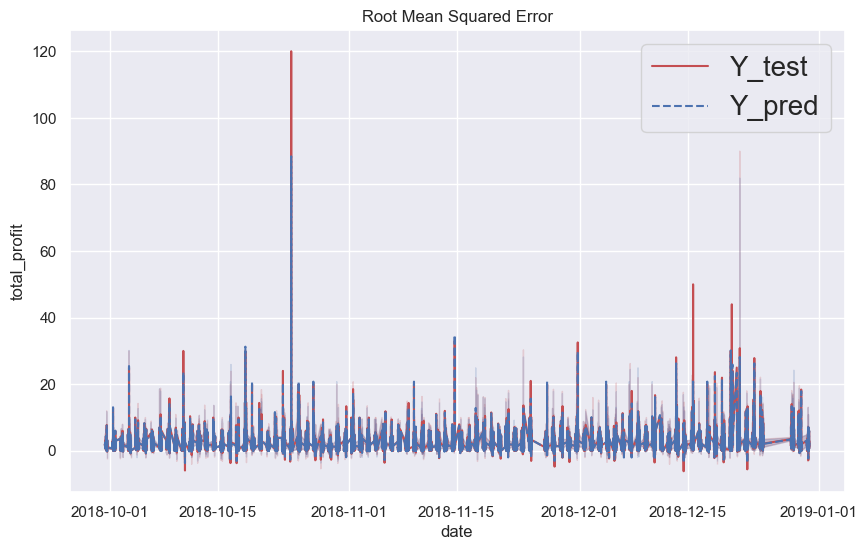

In [63]:
fig1, ax = plt.subplots(figsize=(10, 6))
#fig1.suptitle('Root Mean Squared Error')
sns.lineplot(x= df_test['date'], y = Y_test, color = 'r',label = "Y_test", ax = ax).set_title("Root Mean Squared Error")
sns.lineplot(x= df_test['date'], y = Y_pred, color = 'b', label = "Y_pred", ls="--", ax = ax)
plt.legend(fontsize = 20)
#ax.set_xlabel("Epochs")
plt.show()

In [60]:
print("RMSE of XGBoost Model: ", mean_squared_error(y_true=Y_test, y_pred=Y_pred, squared=False))

RMSE of XGBoost Model:  0.3048410374540411


In [29]:
# PLotting the results of the above model

train_rmse = [2.41211,1.30492,0.81963,0.56251,0.40824,0.31578,0.25657,0.21751,0.19179,0.17416,0.16229]
test_rmse = [2.63353,1.5385,1.03866,0.74482,0.56976,0.46823,0.40277,0.36302,0.33643,0.31723,0.30484]

xaxis = [0,100,200,300,400,500,600,700,800,900,999]


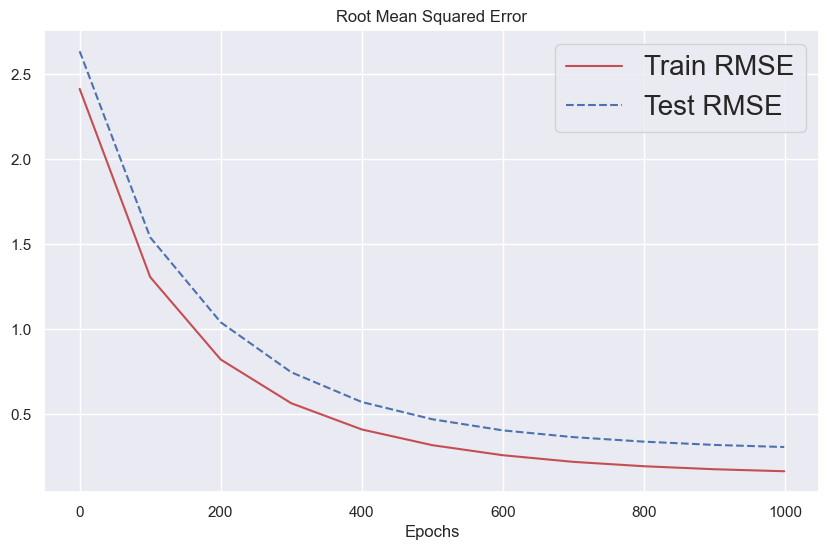

In [64]:
fig1, ax = plt.subplots(figsize=(10, 6))
#fig1.suptitle('Root Mean Squared Error')
sns.lineplot(x= xaxis, y = train_rmse, color = 'r',label = "Train RMSE", ax = ax).set_title("Root Mean Squared Error")
sns.lineplot(x= xaxis, y = test_rmse, color = 'b', label = "Test RMSE", ls="--", ax = ax)
plt.legend(fontsize = 20)
ax.set_xlabel("Epochs")

fig1.savefig("Model2result.png")
plt.show()

### Original XGBoost Model used in Datathon2023 submission

In [27]:
data_dmatrix = xgb.DMatrix(data=X_train,label=Y_train, enable_categorical = True)

xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', 
                          colsample_bytree = 0.3, 
                          learning_rate = 0.1,
                          max_depth = 5, 
                          alpha = 10, 
                          n_estimators = 10)

xg_reg.fit(X_train,Y_train, 
           eval_set=[(X_train, Y_train), (X_test, Y_test)],
           verbose=True)

[0]	validation_0-rmse:2.33360	validation_1-rmse:2.55287
[1]	validation_0-rmse:2.24703	validation_1-rmse:2.46166
[2]	validation_0-rmse:2.14113	validation_1-rmse:2.34076
[3]	validation_0-rmse:2.04682	validation_1-rmse:2.24630
[4]	validation_0-rmse:1.96749	validation_1-rmse:2.16087
[5]	validation_0-rmse:1.88759	validation_1-rmse:2.07632
[6]	validation_0-rmse:1.84689	validation_1-rmse:2.03744
[7]	validation_0-rmse:1.81164	validation_1-rmse:1.99611
[8]	validation_0-rmse:1.78521	validation_1-rmse:1.96662
[9]	validation_0-rmse:1.75672	validation_1-rmse:1.93356


XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=10, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=10, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)